# Versionamento

V2: 
<ul>
    <li>Inclusão da variável categórica x28 que está relacionada com o tipo de papel em produção</li>
    <li>Feature Selection</li>
    <li>Feature Scalling</li>
</ul>

V3:
<ul>
    <li>Ajuste de parâmetros dos modelos</li>
    <li> V2: correção da função lstm_data_transform para pegar o target correto</li>
</ul>

V4:
<ul>
    <li>Redução de feature usando resultado do PCA (notebook DimRedPCAOnTS) </li>
    <li>num_steps de 30 para 10</li>
</ul>

V6:
<ul>
    <li>Redução de features Processo Manual </li>
    <li>Manual Data Augmentation</li>
</ul>

V6-Multi
<ul>
    <li>Remoção de Break Avalanche (breaks em menos de uma hora) e maiores que 3 horas</li>
    <li>Classificação multi lable (1, 2 ou 3 horas)  </li>
</ul>


# O problema

Paper manufacturing can be viewed as a continuous rolling process. During this process, sometimes the paper breaks. If a break happens, the entire process is stopped, the reel is taken out, any found problem is fixed, and the production is resumed. The resumption can take more than an hour.

The cost of this lost production time is significant for a mill. Even a 5% reduction in the break events will give a significant cost saving for a mill. The objective of the given problem is to predict such breaks in advance (early prediction) and identify the potential cause(s) to prevent the break. 

To build such a prediction model, we will use the data collected from the network of sensors in a mill.

This is a multivariate time series data with break as the response (a
binary variable).
The provided data has,
<ul>
    <li>18,398 records.</li>
    <li>Columns:</li>
        <ul>
        <li>time: the timestamp of the row</li>
        <li>y: the binary response variable. There are only 124 rows with y = 1, rest are y = 0.</li>
        <li>x1-x61: predictor variables. All the predictors are continuous variables, except x28 and x61. x61 is a binary variable, and x28 is a
        categorical variable. All the predictors are centered. Besides, the predictors are a mixture of raw materials and process variables. Their descriptions are omitted for data anonymity.
            Several sensors are placed in different parts of the machine along its length
and breadth. These sensors measure both raw materials (e.g. amount of pulp
fiber, chemicals, etc.) and process variables (e.g. blade type, couch vacuum,
rotor speed, etc.).</li>
        </ul>
</ul>

# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import multilabel_confusion_matrix, recall_score, precision_score, accuracy_score, plot_confusion_matrix
import datetime

# Load Data

In [2]:
pwbdatafile = '..\\data\\pwb-data-augmented.csv'
pwbds = pd.read_csv(pwbdatafile)
pwbds.drop('Unnamed: 0',axis=1,inplace=True)

## Cálculo do Remaining Usefull Lifecycle (RUL)

In [3]:
# Dates whith break
df_sub = sorted(pwbds[pwbds['y'] == 1]['timestamp'].tolist())

In [4]:
# variable to store all days
breakSubIdx=0
breakLstIdx=0
breakList = pwbds['y'].tolist()
nextbreak = []
for v1 in pwbds['timestamp'].tolist():
    if((breakList[breakLstIdx] == 1)):
#        print ('1')
        nextbreak.append(v1)
        breakSubIdx = breakSubIdx+1
    else:
#        print('0')
        if (breakSubIdx < len(df_sub)):
            nextbreak.append(df_sub[breakSubIdx])
        else:
            nextbreak.append(df_sub[breakSubIdx-1])
    breakLstIdx = breakLstIdx+1
pwbds['nextbreaktime'] = pd.Series(nextbreak)

In [5]:
pwbds['RUL']=(pwbds['nextbreaktime']-pwbds['timestamp'])
#pwbds.drop(pwbds[pwbds.RUL < 0].index, inplace=True)
pwbds.drop(['timestamp','nextbreaktime'], axis=1, inplace=True)

### Verificando cálculo do RUL

In [6]:
pwbds[pwbds.y==1]

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x53,x54,x55,x56,x57,x58,x59,x60,x61,RUL
259,1,0.892311,-13.332664,-10.006578,2.855933,-0.448832,15.986336,0.000732,-0.061114,-0.030057,...,-0.752385,-5.015553,-75.896664,69.585016,3.113292,0.032223,5.685793,0.007663,1,0
776,1,-0.782471,-12.118747,-16.855194,-322.781610,-0.738810,25.966042,0.040711,-0.071186,0.012574,...,-5.337590,2.680329,-7.209775,-37.195777,1.642284,0.013798,2.664362,0.007856,0,0
835,1,-0.697450,-1.696176,4.145142,121.152838,-0.598597,-7.789024,0.060853,0.048752,-0.120087,...,-6.368351,2.568616,-26.245907,-74.477362,-0.097279,0.015905,2.700281,0.007745,0,0
1036,1,-0.791718,-0.076644,-1.012134,162.257269,-0.062876,9.005471,0.005767,0.033764,-0.120087,...,-6.856144,2.703874,-29.833432,-53.421866,-1.165393,0.019691,3.348276,0.006241,0,0
1263,1,-1.212083,-2.326809,0.922287,31.935858,-0.920100,14.183205,-0.089298,0.028915,-0.120087,...,-6.856144,2.762956,0.965763,-49.512961,-0.219349,0.041640,2.740404,0.005131,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52626,1,-0.367076,-8.876281,-9.826331,-81.548181,0.719656,-31.805839,-0.058545,-0.000993,0.009922,...,10.091365,3.105512,101.055728,-59.396201,-2.111499,0.001227,1.458925,0.018978,0,0
52630,1,0.381548,-7.119146,-7.791697,-68.089395,0.172140,-61.932670,0.000732,-0.101094,0.009922,...,5.405574,-5.013181,-46.756772,-52.525641,-0.860218,0.016202,3.409899,0.007643,0,0
52708,1,0.386066,-9.029249,-8.759439,83.883705,-0.509745,52.357521,0.180791,0.268791,0.139931,...,1.914363,3.143712,18.257755,-72.250327,-1.775806,-0.149790,-0.102720,0.000803,1,0
52892,1,-0.082568,-8.880742,-16.979639,61.011024,-0.183390,26.041847,-0.059389,-0.091023,-0.040129,...,3.983455,-4.996303,-31.832699,54.449090,3.473400,0.011233,1.377375,0.007596,0,0


In [7]:
pwbds.iloc[257:262,][['y','RUL']]

,y,RUL
257,0,2
258,0,1
259,1,0
260,0,516
261,0,515


In [8]:
pwbds.describe()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x53,x54,x55,x56,x57,x58,x59,x60,x61,RUL
count,52901.000000,52901.000000,52901.000000,52901.000000,52901.000000,52901.000000,52901.000000,52901.000000,52901.000000,52901.000000,...,52901.000000,52901.000000,52901.000000,52901.000000,52901.000000,52901.000000,52901.000000,52901.000000,52901.000000,52901.000000
mean,0.006862,0.057318,0.071103,0.500544,-14.627456,0.009204,1.623773,0.006993,-0.003758,-0.005368,...,0.450461,0.084254,1.141146,10.152005,0.296800,-0.002433,0.383132,0.001676,0.001077,178.428688
std,0.082553,0.685456,4.717738,5.805865,131.369354,0.644561,37.207917,0.105115,0.069699,0.146264,...,14.470646,3.060186,68.392643,82.087866,2.354669,0.049561,8.044379,0.004334,0.032808,159.602377
min,0.000000,-3.787279,-17.316550,-18.198509,-322.781610,-1.623988,-279.408440,-0.429273,-0.451141,-0.120087,...,-1817.595500,-8.210370,-230.574030,-269.039500,-12.640370,-0.149790,-100.810500,-0.006964,0.000000,0.000000
25%,0.000000,-0.343774,-2.254215,-3.616665,-112.744840,-0.452250,-26.403740,-0.049319,-0.051043,-0.059966,...,-1.821965,0.434740,-41.929135,-46.152106,-1.714771,0.000625,0.296717,-0.001549,0.000000,49.000000
50%,0.000000,0.147292,-0.165148,-0.447418,-19.511743,-0.125300,9.528359,0.000732,-0.011064,-0.030057,...,0.345516,0.641552,17.738101,3.316736,0.146862,0.013043,0.744997,0.001104,0.000000,133.000000
75%,0.000000,0.433430,2.149377,3.318041,83.945716,0.344991,31.551491,0.060853,0.038986,-0.000149,...,3.857723,2.670477,43.342594,64.184320,2.222118,0.021175,1.280115,0.004578,0.000000,270.000000
max,1.000000,3.054156,16.734899,15.900116,334.694098,4.239385,96.060768,1.705590,0.788826,3.206675,...,11.148006,6.475137,287.252017,252.147455,6.922008,0.060264,6.985460,0.020510,1.000000,762.000000


## Remove Break Avalanche 

In [9]:
def removeBreakAvalanche (fullds):
    clean_ds = pd.DataFrame([])
    breaks = np.array(np.where(pwbds['y'] == 1)).reshape(-1)
    start = 0 
    for breakpt in breaks:
        if (breakpt-start >= 30):
            clean_ds = clean_ds.append(fullds.iloc[start:breakpt+1,],ignore_index = True)
        start = breakpt+1
    return (clean_ds)

In [10]:
clean_ds = removeBreakAvalanche(pwbds)
#clean_ds = pwbds

In [11]:
clean_ds.shape

(51212, 63)

In [12]:
clean_ds.describe()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x53,x54,x55,x56,x57,x58,x59,x60,x61,RUL
count,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,...,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000
mean,0.004745,0.050461,0.088054,0.638865,-15.212512,0.012046,2.867002,0.005429,-0.004413,-0.008527,...,0.412822,0.185933,1.829511,11.952184,0.296988,-0.002571,0.363890,0.001611,0.000644,184.004999
std,0.068721,0.675284,4.767542,5.817390,131.438198,0.649975,36.421118,0.104610,0.067639,0.138477,...,14.684128,3.011745,68.354633,82.256222,2.355087,0.049748,8.173235,0.004275,0.025377,159.177196
min,0.000000,-3.787279,-17.316550,-18.198509,-322.781610,-1.623988,-279.408440,-0.429273,-0.451141,-0.120087,...,-1817.595500,-5.370937,-230.574030,-269.039500,-12.640370,-0.149790,-100.810500,-0.006964,0.000000,0.000000
25%,0.000000,-0.346791,-2.259969,-3.463973,-112.978430,-0.454295,-19.421226,-0.049319,-0.051043,-0.059966,...,-1.980900,0.497023,-40.634335,-44.464499,-1.720875,0.000753,0.297320,-0.001610,0.000000,56.000000
50%,0.000000,0.144114,-0.158786,-0.268385,-19.380945,-0.128397,10.098061,0.000732,-0.011064,-0.030057,...,0.291561,0.660142,18.540958,5.321893,0.146862,0.012858,0.746096,0.001064,0.000000,139.000000
75%,0.000000,0.423192,2.213771,3.439507,83.836585,0.353445,32.113739,0.060853,0.038986,-0.000149,...,3.739315,2.679877,43.373112,66.369623,2.222118,0.021139,1.280321,0.004356,0.000000,276.000000
max,1.000000,3.054156,16.734899,15.900116,296.772589,4.239385,68.886910,1.705590,0.453273,3.206675,...,11.148006,6.475137,283.522037,252.147455,6.922008,0.060264,6.985460,0.020510,1.000000,762.000000


## Marcação de falha no próximo período 

Using RUL, we can create a label indicating time to failure. We define a boolean (True\False) value for NEXT_H indicating the engine will fail within 60 minutes (RUL  <=60 ). 

We can also define a multiclass MULTI  ∈{0,1,2}  indicating {Healthy, RUL <=60, RUL <=120} minutes.

In [13]:
clean_ds['BRK_WINDOW']=0

In [14]:
clean_ds.describe()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x54,x55,x56,x57,x58,x59,x60,x61,RUL,BRK_WINDOW
count,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,...,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.0
mean,0.004745,0.050461,0.088054,0.638865,-15.212512,0.012046,2.867002,0.005429,-0.004413,-0.008527,...,0.185933,1.829511,11.952184,0.296988,-0.002571,0.363890,0.001611,0.000644,184.004999,0.0
std,0.068721,0.675284,4.767542,5.817390,131.438198,0.649975,36.421118,0.104610,0.067639,0.138477,...,3.011745,68.354633,82.256222,2.355087,0.049748,8.173235,0.004275,0.025377,159.177196,0.0
min,0.000000,-3.787279,-17.316550,-18.198509,-322.781610,-1.623988,-279.408440,-0.429273,-0.451141,-0.120087,...,-5.370937,-230.574030,-269.039500,-12.640370,-0.149790,-100.810500,-0.006964,0.000000,0.000000,0.0
25%,0.000000,-0.346791,-2.259969,-3.463973,-112.978430,-0.454295,-19.421226,-0.049319,-0.051043,-0.059966,...,0.497023,-40.634335,-44.464499,-1.720875,0.000753,0.297320,-0.001610,0.000000,56.000000,0.0
50%,0.000000,0.144114,-0.158786,-0.268385,-19.380945,-0.128397,10.098061,0.000732,-0.011064,-0.030057,...,0.660142,18.540958,5.321893,0.146862,0.012858,0.746096,0.001064,0.000000,139.000000,0.0
75%,0.000000,0.423192,2.213771,3.439507,83.836585,0.353445,32.113739,0.060853,0.038986,-0.000149,...,2.679877,43.373112,66.369623,2.222118,0.021139,1.280321,0.004356,0.000000,276.000000,0.0
max,1.000000,3.054156,16.734899,15.900116,296.772589,4.239385,68.886910,1.705590,0.453273,3.206675,...,6.475137,283.522037,252.147455,6.922008,0.060264,6.985460,0.020510,1.000000,762.000000,0.0


In [15]:
clean_ds.loc[pwbds['RUL'] > 60 , 'BRK_WINDOW'] = 2
clean_ds.loc[(pwbds['RUL'] <= 60) & (clean_ds['RUL'] > 30) , 'BRK_WINDOW'] = 1
clean_ds.loc[(pwbds['RUL'] <= 30) , 'BRK_WINDOW'] = 0

In [16]:
clean_ds.describe()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x54,x55,x56,x57,x58,x59,x60,x61,RUL,BRK_WINDOW
count,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,...,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000,51212.000000
mean,0.004745,0.050461,0.088054,0.638865,-15.212512,0.012046,2.867002,0.005429,-0.004413,-0.008527,...,0.185933,1.829511,11.952184,0.296988,-0.002571,0.363890,0.001611,0.000644,184.004999,1.521636
std,0.068721,0.675284,4.767542,5.817390,131.438198,0.649975,36.421118,0.104610,0.067639,0.138477,...,3.011745,68.354633,82.256222,2.355087,0.049748,8.173235,0.004275,0.025377,159.177196,0.794218
min,0.000000,-3.787279,-17.316550,-18.198509,-322.781610,-1.623988,-279.408440,-0.429273,-0.451141,-0.120087,...,-5.370937,-230.574030,-269.039500,-12.640370,-0.149790,-100.810500,-0.006964,0.000000,0.000000,0.000000
25%,0.000000,-0.346791,-2.259969,-3.463973,-112.978430,-0.454295,-19.421226,-0.049319,-0.051043,-0.059966,...,0.497023,-40.634335,-44.464499,-1.720875,0.000753,0.297320,-0.001610,0.000000,56.000000,1.000000
50%,0.000000,0.144114,-0.158786,-0.268385,-19.380945,-0.128397,10.098061,0.000732,-0.011064,-0.030057,...,0.660142,18.540958,5.321893,0.146862,0.012858,0.746096,0.001064,0.000000,139.000000,2.000000
75%,0.000000,0.423192,2.213771,3.439507,83.836585,0.353445,32.113739,0.060853,0.038986,-0.000149,...,2.679877,43.373112,66.369623,2.222118,0.021139,1.280321,0.004356,0.000000,276.000000,2.000000
max,1.000000,3.054156,16.734899,15.900116,296.772589,4.239385,68.886910,1.705590,0.453273,3.206675,...,6.475137,283.522037,252.147455,6.922008,0.060264,6.985460,0.020510,1.000000,762.000000,2.000000


In [17]:
clean_ds['BRK_WINDOW'].value_counts()

2    36476
0     9762
1     4974
Name: BRK_WINDOW, dtype: int64

In [18]:
# Remove previsões acima de 3 horas
#clean_ds.drop(clean_ds[clean_ds.BRK_WINDOW >=4].index, inplace=True)

In [19]:
clean_ds['BRK_WINDOW'].value_counts()

2    36476
0     9762
1     4974
Name: BRK_WINDOW, dtype: int64

In [20]:
clean_ds = clean_ds.reset_index(drop=True)

In [21]:
clean_ds['BRK_WINDOW'].value_counts()

2    36476
0     9762
1     4974
Name: BRK_WINDOW, dtype: int64

In [22]:
Y = clean_ds['BRK_WINDOW'].astype(int)

# Feature Selection and Scaling

In [23]:
# Feature Selection
# List of considered Features

FEATURES = [
    'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20',
    'x21','x22','x23','x24','x25','x26','x27','x28','x29','x30','x31','x32','x33','x34','x35','x36','x37','x38','x39','x40',
    'x41','x42','x43','x44','x45','x46','x47','x48','x49','x50','x51','x52','x53','x54','x55','x56','x57','x58','x59','x60'
#]
# Redução de feature usando resultado do PCA (notebook DimRedPCAOnTS)
#    'x1','x5','x8','x10','x13','x14','x15','x17','x18','x19','x20','x21','x22','x26','x28','x30','x31','x34',
#    'x35','x37','x38','x40','x41','x43','x46','x48','x49','x51','x53','x54','x55','x58'

# Usando as features com base na sua relação com RUL
#    'x4','x24','x48','x58','x60','x42','x45','x61','x46','x49','x9','x10','x38','x17','x5','x28','x33','x41',   
#    'x13','x16','x56','x8','x12','x1','x57','x50','x44','x47','x52','x27','x37','x3','x54','x26','x2','x29','x55'

# Cj 1 - Não usar: derrubou métricas quando adicionado ao Cj 4 + Cj 6
#    'x1','x2','x4','x5','x6','x7','x10', 'x11','x13','x15','x17','x28',
#    'x1','x5','x10','x13','x14','x15',
    
# Cj 2
# Medidos sem C3:
#    'x3','x8','x10','x12','x13','x16','x18','x19','x20','x23','x25', # Precision: 0.781, Recall: 0.390, F1: 0.520
#    'x3','x8','x10','x12','x13','x16',                               # Precision: 0.834, Recall: 0.375, F1: 0.518
#    'x18','x19','x20','x23','x25',                                   # Precision: 0.980, Recall: 0.156, F1: 0.269
#    'x3','x8','x10','x18','x19','x20',                               # Precision: 0.848, Recall: 0.251, F1: 0.387
#    'x12','x13','x16','x23','x25',                                   # Precision: 0.900, Recall: 0.218, F1: 0.351
# Medidos com C3:
###    'x3','x8','x10','x12','x13','x16','x18','x19','x20','x23','x25',  # Precision: 0.735, Recall: 0.470, F1: 0.573

    # Cj 3
###   'x9','x21','x22','x24','x26','x27','x29','x30',                   # Precision: 0.735, Recall: 0.470, F1: 0.573
#    'x9','x21','x22','x24',                                          # Precision: 0.785, Recall: 0.451, F1: 0.573
#    'x26','x27','x29','x30',                                         # Precision: 0.766, Recall: 0.406, F1: 0.530
#    'x9','x21','x29','x30',                                          # Precision: 0.742, Recall: 0.353, F1: 0.478
#    'x22','x24','x26','x27',                                          # Precision: 0.801, Recall: 0.383, F1: 0.518   
    
# Cj 4
###    'x28','x36','x37','x38','x39','x40','x31','x32','x33','x34','x35',
    
# Cj 5
#    'x41','x42','x43','x44','x45','x46','x47','x48','x49','x52',

# Cj 6
###   'x50','x51','x53','x54','x55','x56','x57','x58','x59','x60',
]

# Create the dataset with features and filter the data to the list of FEATURES
clean_ds_filtered = clean_ds[FEATURES]

# Print the tail of the dataframe
clean_ds_filtered.tail()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
51207,-0.151683,-3.954797,-4.299529,62.011024,-0.096552,25.731026,-0.059389,-0.091023,-0.030057,0.001791,...,27.413823,11.055832,4.041316,-4.996629,-31.080624,60.825372,4.114269,0.011547,1.405894,0.007603
51208,-0.186095,-4.056258,-4.205272,58.932471,-0.118266,25.050453,-0.059389,-0.091023,-0.040129,-0.001682,...,27.467778,11.113205,4.026912,-4.996548,-31.341977,58.203699,4.114269,0.011469,0.341051,0.007601
51209,-0.141189,-3.946290,-4.257756,64.271431,-0.139964,25.380898,-0.059389,-0.091023,-0.040129,-0.008280,...,27.521489,11.170578,4.012264,-4.996466,-31.505551,55.582056,3.473400,0.011390,0.110140,0.007599
51210,-0.163747,-6.551871,-6.632444,62.363684,-0.161677,25.711373,-0.059389,-0.091023,-0.040129,-0.008280,...,27.575444,11.227951,3.997859,-4.996385,-31.669125,54.916864,4.175304,0.011312,0.718683,0.007598
51211,-0.082568,-8.880742,-16.979639,61.011024,-0.183390,26.041847,-0.059389,-0.091023,-0.040129,-0.008280,...,27.629399,11.280441,3.983455,-4.996303,-31.832699,54.449090,3.473400,0.011233,1.377375,0.007596


In [24]:
# This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from sklearn.preprocessing import RobustScaler, MinMaxScaler 

# Get the number of rows in the data
nrows = clean_ds_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(clean_ds_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)
clean_ds_scaled = pd.DataFrame(
    np_data_scaled,
    columns=FEATURES
)

(51212, 60)


# Shaping & Splitting

In [25]:
def lstm_data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        
        # if index is larger than the size of the dataset, we stop
        if end_ix > x_data.shape[0]:
            break
        
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix-1]
        
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

# Modeling 2: Multicategorical Classification - Break in the next hour

## Dataset for model 2

In [26]:
X = clean_ds_scaled

In [27]:
Y.value_counts()

2    36476
0     9762
1     4974
Name: BRK_WINDOW, dtype: int64

In [28]:
X.shape

(51212, 60)

In [29]:
Y.shape

(51212,)

### Apply PCA

In [30]:
from sklearn.decomposition import PCA # for PCA calculation
pca = PCA()
X_pca = pca.fit(X)

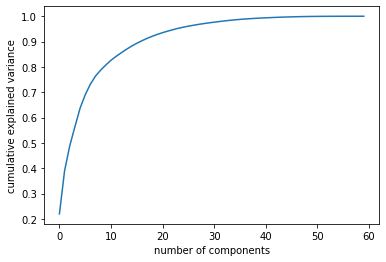

In [31]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [32]:
num_components = 40
pca = PCA(num_components)  
X_pca = pca.fit_transform(X) # fit and reduce dimension

In [33]:
num_steps = 5 # Intervalo entre medições é de 2 minutos
x_new, y_new = lstm_data_transform(X_pca, Y, num_steps=num_steps)
print ("The new shape of x is", x_new.shape)

The new shape of x is (51208, 5, 40)


In [34]:
train_ind = int(0.7 * len(X_pca))
x_train = x_new[:train_ind]
y_train = y_new[:train_ind]
x_test = x_new[train_ind:]
y_test = y_new[train_ind:]

In [35]:
# Usar, caso optar por categorigal_crossentropy
#y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
#y_test  = tf.keras.utils.to_categorical(y_test,  num_classes=4)

In [36]:
x_test.shape

(15360, 5, 40)

In [37]:
y_train

array([2, 2, 2, ..., 2, 2, 2])

# Model 2

In [38]:
import tensorflow as tf
from keras.models import Sequential
from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM, Activation
from tensorflow.keras import layers


C:\Users\hcord\anaconda3\envs\paper3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hcord\anaconda3\envs\paper3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hcord\anaconda3\envs\paper3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hcord\anaconda3\envs\paper3\lib\site-packages\tensorflow\pyth

In [39]:
print(tf. __version__)
print(np. __version__)
from platform import python_version

print(python_version())

1.14.0
1.19.5
3.6.9


In [40]:
x_train.shape[2]

40

In [41]:
# LSTM model
model = keras.Sequential()

# The first layer
model.add(layers.Bidirectional(layers.LSTM(
         input_shape=(num_steps, x_train.shape[2]),
         units=120,
         activation='tanh',
         return_sequences=True)))
model.add(layers.BatchNormalization())

# Plus a 20% dropout rate
model.add(layers.Dropout(0.2))

# The second layer
model.add(layers.Bidirectional(layers.LSTM(
          units=60,
          return_sequences=False)))
model.add(layers.BatchNormalization())

# Plus a 20% dropout rate
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=60, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=30, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=10, activation='relu'))
model.add(layers.Dropout(0.2))

# Dense sigmoid layer
model.add(layers.Dense(3, activation='sigmoid'))

# With adam optimizer and a binary crossentropy loss. We will opimize for model accuracy.
adam = keras.optimizers.Adam(lr=0.0001,amsgrad=True)
adagrad = keras.optimizers.Adagrad(learning_rate=0.001,initial_accumulator_value=0.1, epsilon=1e-07)
rmsprop = keras.optimizers.RMSprop(learning_rate=0.001,rho=0.9, momentum=0.001, epsilon=1e-07)

metrics = [
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
]

model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [42]:
# EarlyStopping Callback
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [43]:
x_test.shape

(15360, 5, 40)

In [44]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2]), array([ 6935,  3476, 25437], dtype=int64))

In [45]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2]), array([ 6935,  3476, 25437], dtype=int64))

In [46]:
history = model.fit(
    x_train, 
    y_train, 
    epochs=60,
#    batch_size=60,
    validation_split=0.20,
    callbacks = [callback])

Train on 28678 samples, validate on 7170 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/60
28678/28678 [==============================] - 25s 883us/sample - loss: 0.9961 - acc: 0.5795 - val_loss: 0.8868 - val_acc: 0.7152
Epoch 2/60
28678/28678 [==============================] - 21s 735us/sample - loss: 0.8740 - acc: 0.6899 - val_loss: 0.8309 - val_acc: 0.7197
Epoch 3/60
28678/28678 [==============================] - 25s 861us/sample - loss: 0.8134 - acc: 0.6974 - val_loss: 0.8259 - val_acc: 0.7165
Epoch 4/60
28678/28678 [==============================] - 23s 799us/sample - loss: 0.7803 - acc: 0.7007 - val_loss: 0.8582 - val_acc: 0.7166
Epoch 5/60
28678/28678 [==============================] - 22s 760us/sample - loss: 0.7513 - acc: 0.7096 - val_loss: 0.9000 - val_acc: 0.6967
Epoch 6/60
28678/28678 [==============================] - 23s 792us/sample - loss: 0.7306 - acc: 0.7160 - val_loss: 0.9850 - val_acc: 0.7045
Epoch 7/60


Epoch 56/60
28678/28678 [==============================] - 22s 781us/sample - loss: 0.4552 - acc: 0.7655 - val_loss: 3.3325 - val_acc: 0.5886
Epoch 57/60
28678/28678 [==============================] - 23s 787us/sample - loss: 0.4572 - acc: 0.7651 - val_loss: 3.3302 - val_acc: 0.5894
Epoch 58/60
28678/28678 [==============================] - 21s 746us/sample - loss: 0.4542 - acc: 0.7670 - val_loss: 3.2944 - val_acc: 0.5877
Epoch 59/60
28678/28678 [==============================] - 22s 760us/sample - loss: 0.4487 - acc: 0.7695 - val_loss: 3.3187 - val_acc: 0.5902
Epoch 60/60
28678/28678 [==============================] - 22s 775us/sample - loss: 0.4445 - acc: 0.7686 - val_loss: 3.3733 - val_acc: 0.5874


In [47]:
# Verify the architecture 
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional multiple                  154560    
_________________________________________________________________
batch_normalization (BatchNo multiple                  960       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  144480    
_________________________________________________________________
batch_normalization_1 (Batch multiple                  480       
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  7

In [48]:
x_test.shape

(15360, 5, 40)

Text(0.5, 0, 'epochs')

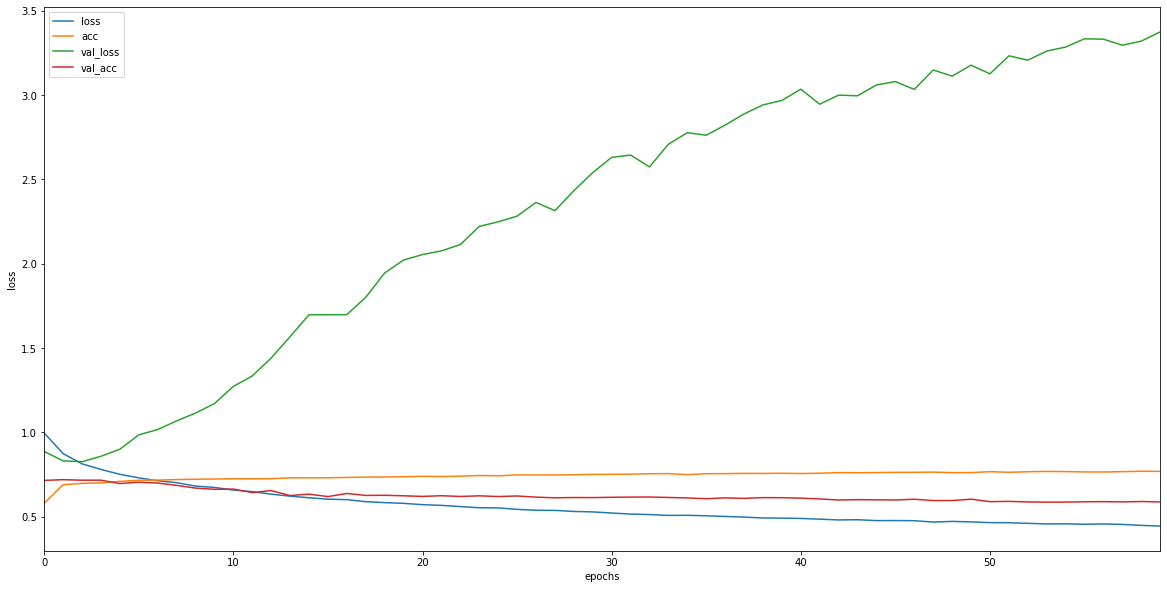

In [49]:
# Plot History
pd.DataFrame(history.history).plot(figsize=(20, 10))
plt.ylabel('loss')
plt.xlabel('epochs')


In [50]:
#scores_2 = model.evaluate(x_test, y_test, verbose=1, batch_size=200)
scores_2 = model.evaluate(x_test, y_test, verbose=1)
print('Test Accurracy: {}'.format(scores_2[1]))

15360/15360 [==============================] - 2s 154us/sample - loss: 2.7874 - acc: 0.6360
Test Accurracy: 0.6360026001930237


In [51]:
# make predictions and compute confusion matrix
#y_pred = model.predict_classes(x_test,verbose=1, batch_size=200)
y_pred = model.predict_classes(x_test,verbose=1)
cm = multilabel_confusion_matrix(y_test.astype(int), y_pred)
cm

15360/15360 [==============================] - 3s 163us/sample


array([[[11386,  1147],
        [ 2449,   378]],

       [[13038,   824],
        [ 1400,    98]],

       [[  705,  3620],
        [ 1742,  9293]]], dtype=int64)

In [52]:
# compute precision and recall
accuracy_test = accuracy_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred, average=None)
recall_test = recall_score(y_test, y_pred, average=None)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print('Test Accuracy: ', accuracy_test, '\n', 'Test Precision: ', precision_test, '\n', 'Test Recall: ', recall_test, '\n', 'Test F1 Score:', f1_test)

Test Accuracy:  0.6360026041666667 
 Test Precision:  [0.24786885 0.10629067 0.71966236] 
 Test Recall:  [0.13371065 0.06542056 0.84213865] 
 Test F1 Score: [0.17371324 0.08099174 0.77609821]


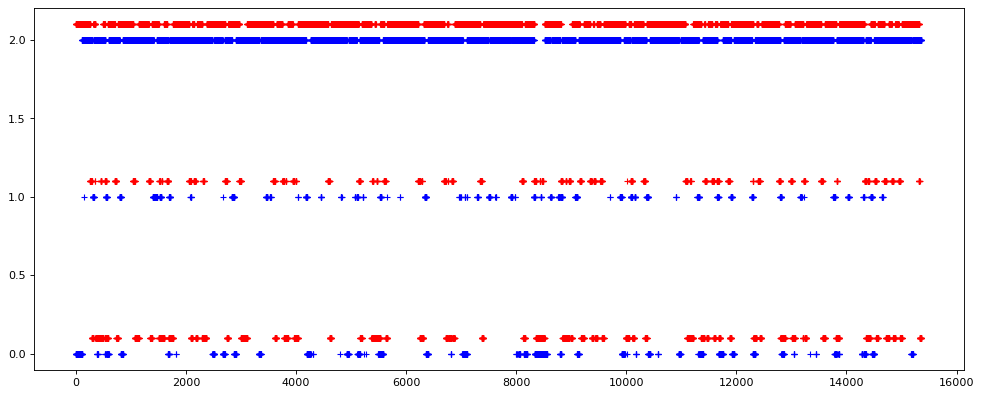

In [53]:
figure(figsize=(15, 6), dpi=80)
plt.plot(y_test+0.1,'r+')
plt.plot(y_pred,'b+')

In [54]:
import shap  # package used to calculate Shap values

# use Deep SHAP to explain test set predictions
#k_explainer = shap.KernelExplainer(model_1.predict_proba, x_test)
#k_shap_values = k_explainer.shap_values(x_test.reshape(14315*30,32))
#shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], x_test)

## Salvando o modelo

In [55]:
model.save('../data/pwb_classification_multi')

# Random Forest

In [88]:
train_ind = int(0.7 * len(X_pca))
x_train = X_pca[:train_ind]
y_train = Y[:train_ind]
x_test = X_pca[train_ind:]
y_test = Y[train_ind:]

In [89]:
y_train

0        2
1        2
2        2
3        2
4        2
        ..
35843    2
35844    2
35845    2
35846    2
35847    2
Name: BRK_WINDOW, Length: 35848, dtype: int32

In [90]:
from sklearn.ensemble import RandomForestClassifier as rfc
clf_rf = rfc(random_state=0).fit(x_train, y_train)

In [91]:
clf_rf.score(x_test, y_test)

0.6029679770892996

In [92]:
y_pred = clf_rf.predict(x_test)

In [93]:
cm = multilabel_confusion_matrix(y_test, y_pred)
cm

array([[[10710,  1827],
        [ 2322,   505]],

       [[12916,   950],
        [ 1326,   172]],

       [[ 1002,  3323],
        [ 2452,  8587]]], dtype=int64)

In [96]:
# compute precision and recall
accuracy_test = accuracy_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred, average=None)
recall_test = recall_score(y_pred, y_pred, average=None)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print('Test Accuracy: ', accuracy_test, '\n', 'Test Precision: ', precision_test, '\n', 'Test Recall: ', recall_test, '\n', 'Test F1 Score:', f1_test)

Test Accuracy:  0.6029679770892996 
 Test Precision:  [0.21655232 0.15329768 0.72099076] 
 Test Recall:  [1. 1. 1.] 
 Test F1 Score: [0.35600987 0.26584235 0.83787871]


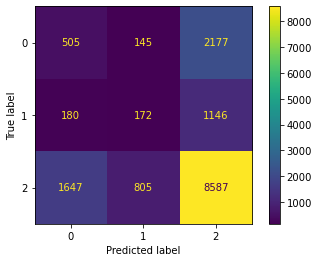

In [97]:
plot_confusion_matrix(clf_rf, x_test, y_test)

In [98]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
#explainer = shap.TreeExplainer(clf_rf)

# Calculate Shap values
#shap_values = explainer.shap_values(x_test)

#shap.initjs()
#shap.force_plot(explainer.expected_value[1], shap_values[1], x_test)


In [99]:
y_test = y_test.reset_index(drop=True)

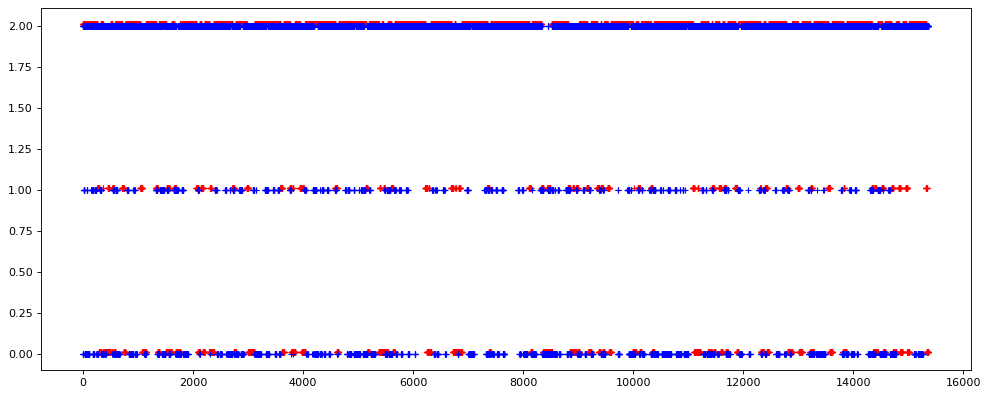

In [100]:
figure(figsize=(15, 6), dpi=80)
plt.plot(y_test+0.01,'r+')
plt.plot(y_pred,'b+')

In [101]:
import joblib
filename = '../data/pwb_classification_rf_multi'
joblib.dump(clf_rf, filename)

['../data/pwb_classification_rf_multi']

# XGBoost

In [102]:
from sklearn.ensemble import GradientBoostingClassifier as xgb

xgbclf = xgb(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(x_train, y_train)
xgbclf.score(x_test, y_test)

0.7032673782869044

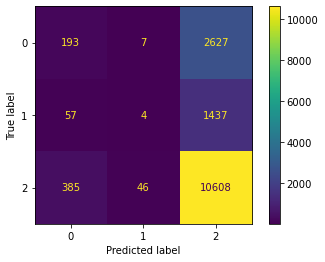

In [103]:
plot_confusion_matrix(xgbclf, x_test, y_test)

In [104]:
y_pred = xgbclf.predict(x_test)

In [105]:
y_test = y_test.reset_index(drop=True)

In [106]:
# compute precision and recall
accuracy_test = accuracy_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred, average=None)
recall_test = recall_score(y_pred, y_pred, average=None)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print('Test Accuracy: ', accuracy_test, '\n', 'Test Precision: ', precision_test, '\n', 'Test Recall: ', recall_test, '\n', 'Test F1 Score:', f1_test)

Test Accuracy:  0.7032673782869044 
 Test Precision:  [0.30393701 0.07017544 0.72300981] 
 Test Recall:  [1. 1. 1.] 
 Test F1 Score: [0.46618357 0.13114754 0.83924051]


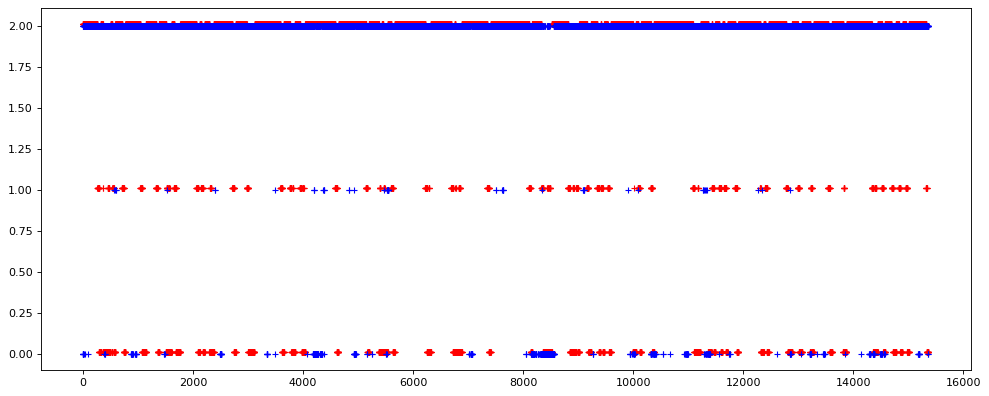

In [107]:
figure(figsize=(15, 6), dpi=80)
plt.plot(y_test+0.01,'r+')
plt.plot(y_pred,'b+')

In [108]:
filename = '../data/pwb_classification_xgb_multi'
joblib.dump(xgbclf, filename)

['../data/pwb_classification_xgb_multi']